In [1]:
spark

In [2]:
df = sqlContext.read.csv('../data/avazu/1M.csv', header=True, inferSchema=True)
df.show()

+-----+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+----+------+---+---------+---+----+
|click|  C1|banner_pos| site_id|site_domain|site_category|  app_id|app_domain|app_category|device_id|device_ip|device_model|device_type|device_conn_type|  C14|C15|C16| C17|C18| C19|   C20|C21|dayofweek|day|hour|
+-----+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+----+------+---+---------+---+----+
|false|1005|         0|1fbe01fe|   f3845767|     28905ebd|ecad2386|  7801e8d9|    07d7df22| a99f214a| c2085c57|    c6263d8a|          1|               0|15699|320| 50|1722|  0|  35|    -1| 79|        1| 21|   6|
|false|1005|         0|85f751fd|   c4e18dd6|     50e219e0|3f2a6cbb|  33da2e74|    cef3e649| a99f214a| af62faf4|    03683bd4|          1|               0

In [3]:
catCols = ['C1'] + [f'C{k}' for k in range(14, 22)]
catCols += ['banner_pos', 'site_category', 'device_type', 'device_conn_type']

In [4]:
from pyspark.sql.functions import udf

In [5]:
posMapper = udf(lambda x: 0 if x < 0 else x)
df = df.withColumn('C20_1', posMapper(df['C20']))

In [6]:
from pyspark.ml.feature import OneHotEncoderEstimator

In [7]:
from pyspark.ml.feature import StringIndexer
si = StringIndexer(inputCol='site_category', outputCol='site_category_ix')
df = si.fit(df).transform(df)
catCols.remove('site_category')
catCols.remove('C20')
catCols.append('site_category_ix')
catCols.append('C20_1')

In [8]:
from pyspark.sql.types import IntegerType
df = df.withColumn("C20_1int", df['C20_1'].cast(IntegerType()))
catCols.remove('C20_1')
catCols.append('C20_1int')

In [9]:
encoder = OneHotEncoderEstimator(inputCols=catCols, outputCols=[c + 'Enc' for c in catCols])
enc_model = encoder.fit(df)
encoded = enc_model.transform(df)

In [10]:
trainCols = [c for c in encoded.columns if c.endswith('Enc')] + ['day', 'hour', 'dayofweek']

In [11]:
encoded = encoded.withColumn('label', encoded['click'].cast(IntegerType()))

In [12]:
from pyspark.ml.classification import LogisticRegression

In [13]:
from pyspark.ml.feature import VectorAssembler

In [14]:
va = VectorAssembler(inputCols=trainCols, outputCol='features')
encoded = va.transform(encoded)

In [15]:
lr = LogisticRegression(featuresCol='features', labelCol='label')

In [23]:
model = lr.fit(encoded)

In [24]:
result = model.evaluate(encoded)

In [26]:
result.accuracy

0.8326408326408327

In [27]:
result.areaUnderROC

0.7033558227769812

In [29]:
encoded.agg({'label': 'mean'}).collect()

[Row(avg(label)=0.1698051698051698)]

In [30]:
1 - 0.16980

0.8302

In [31]:
result.precisionByLabel

[0.8377176222429421, 0.5655623458775598]

In [32]:
result

In [33]:
result.recallByLabel

[0.9902384261991776, 0.06213009039780925]

In [40]:
roc = result.roc.toPandas()

In [41]:
roc.head()

,FPR,TPR
0,0.000000,0.000000
1,0.002954,0.023592
2,0.005683,0.041972
3,0.010134,0.063644
4,0.012932,0.075227


In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

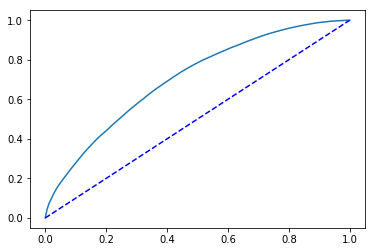

In [47]:
plt.plot(roc['FPR'], roc['TPR'])
plt.plot([0, 1], [0, 1], 'b--')